# **FAKE NEWS CLASSIFICATION**
by

NITHISH BALAJI, MUTHU MANOJ, KANAGALINGAM

GUIDE:
Ms. G. KOTHAI

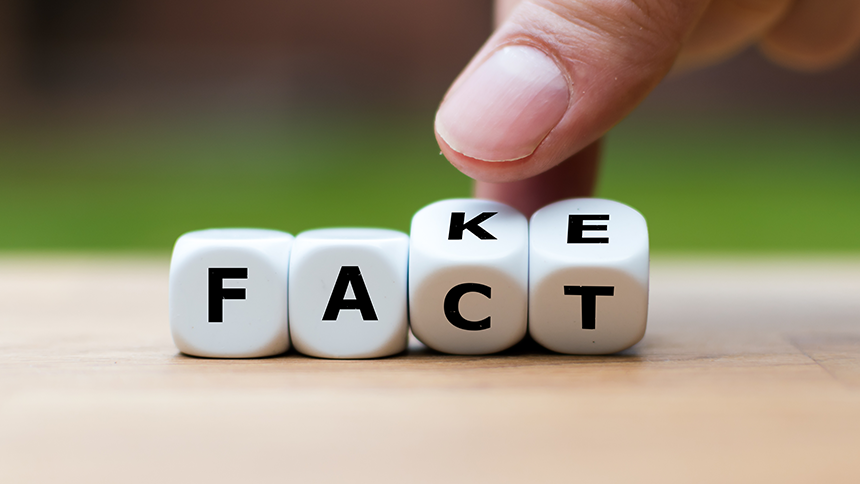

### Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings(action = 'ignore')

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
pd.reset_option('^display.', silent = True)

import random
import math
import gc

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.naive_bayes import BernoulliNB 
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Set random seed
np.random.seed(311)
random.seed(311)

Importing Dataset containing both True and Fake news

In [ ]:
true_df = pd.read_csv('True.csv')
false_df = pd.read_csv('Fake.csv')

Labelling both as 0 and 1

In [ ]:
true_df['class'] = 1
false_df['class'] = 0

fake_news_df = pd.concat([true_df, false_df])

In [ ]:
fake_news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   class    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [ ]:
display(fake_news_df.head(3))

,title,text,subject,date,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1


# **Data Preprocessing**

In [ ]:
# convert text columns to lower case
fake_news_df['title'] = fake_news_df['title'].str.lower()
fake_news_df['text'] = fake_news_df['text'].str.lower()

# remove punctuation
fake_news_df['title'] = fake_news_df['title'].str.replace('[^\w\s]', '')
fake_news_df['text'] = fake_news_df['text'].str.replace('[^\w\s]', '')

fake_news_df['text'].head()

0    washington reuters  the head of a conservative...
1    washington reuters  transgender people will be...
2    washington reuters  the special counsel invest...
3    washington reuters  trump campaign adviser geo...
4    seattlewashington reuters  president donald tr...
Name: text, dtype: object

In [ ]:
fake_news_df['text_combined'] = fake_news_df['title'] + fake_news_df['text']

Select rows where title contains word **Trump**

In [ ]:
fake_news_df = fake_news_df[fake_news_df['title'].str.contains('trump')]
fake_news_df.shape

(14452, 6)

### Look if our classes are balanced

0    8910
1    5542
Name: class, dtype: int64


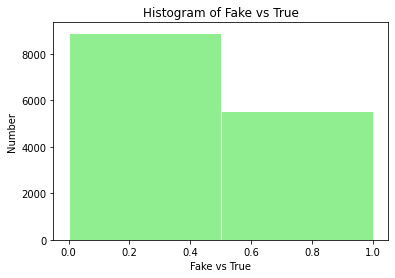

In [ ]:
print(fake_news_df['class'].value_counts())

plt.hist(fake_news_df['class'], color ='lightgreen', edgecolor = 'white', bins = 2)
plt.xlabel('Fake vs True')
plt.ylabel('Number')
plt.title('Histogram of Fake vs True')
plt.show()

Downsample dataset to make classes balanced

In [ ]:
real = fake_news_df[fake_news_df['class'] == 1]
fake = fake_news_df[fake_news_df['class'] == 0]

fake_downsample = resample(fake,
             replace = True,
             n_samples = len(real),
             random_state = 311)

print(fake_downsample.shape)

fake_news_df = pd.concat([real, fake_downsample])

(5542, 6)


Keep the rest of the fake dataset rows that are not a part of the downsampled subset. We will check the size of the real news specific tokens and fake news specific tokens and if fake news has less amount of specific tokens we will extend the vocabularly with tokens from this unused fake text data

In [ ]:
fake_rest_df = fake[~fake.index.isin(fake_downsample.index)]
fake_rest_df.shape

(4829, 6)

**Split the Data for Training and Testing**

In [ ]:
def split_data(data, labels, valid_part_size = 0.15, test_part_size = 0.15):

    # Split the dataset into train, validation, and test
    X_train, X_test, y_train, y_test = train_test_split(
        data, 
        labels, 
        test_size = test_part_size, 
        stratify = labels, 
        random_state = 311
        )
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, 
        y_train, 
        test_size = valid_part_size/(1 - test_part_size), 
        stratify = y_train, 
        random_state = 311
        )

    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

In [ ]:
(X_train, y_train), (X_valid, y_valid), (X_test,y_test) = split_data(
    fake_news_df['text_combined'], 
    fake_news_df['class'], 
    0.15, 
    0.15
)

In [ ]:
X_valid.head(1)

18467    trumps lawyer destroys chriswallace in heated ...
Name: text_combined, dtype: object

# Explore Vocabulary

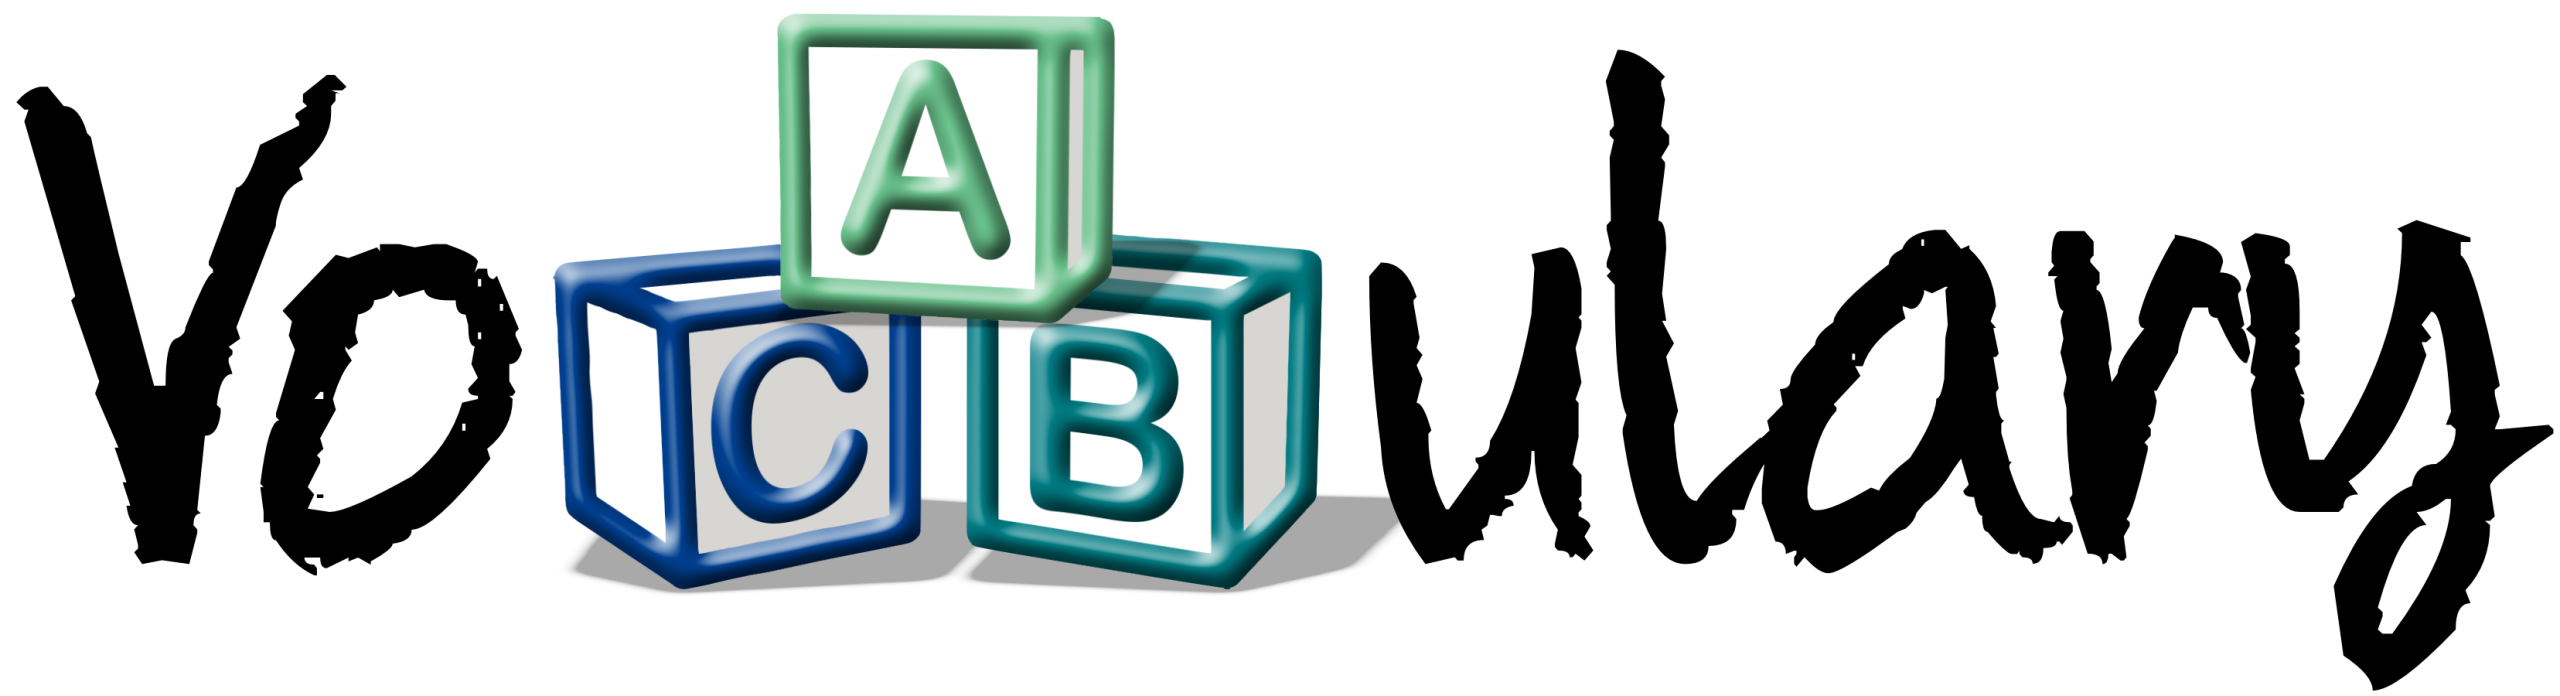

In [ ]:
# Retrieve combined text from the train data
text_data = X_train.tolist()
print(text_data[ : 1])

[' watch deplorable trump supporter punches protester and slaps woman at rallytrump supporters have proven hillary clinton right once againduring a rally in ashville north carolina on monday a trump fan was filmed physically assaulting some protesters with the republican nominee s full support as he gave the thumbs upat the top of some bleachers a middleaged white guy can be seen grabbing and punching a male protester security intervened but rather than remove the trump supporter for committing an actual crime they kicked out the protesters insteadthe man verbally harasses the group as they file out down the steps all while acting like he is some kind of tough guy and then goes as far as slapping a female protester on her way outhere s the video via twitterwatch man slaps several protesters as they are being escorted out of realdonaldtrump rally in asheville nc pictwittercomkmkcdviar4  abc news politics abcpolitics september 12 2016again this asshole did not get removed from the rally 

**Compare size of vocabulary of real news and fake news**
1. Having vocabulary that overlaps

In [ ]:
text_real_facts = X_train[y_train == 1].tolist()
text_fake_facts = X_train[y_train == 0].tolist()

tokens_real_facts = nltk.word_tokenize(' '.join(text_real_facts))
tokens_fake_facts = nltk.word_tokenize(' '.join(text_fake_facts))

vocabulary_real = set(tokens_real_facts)
vocabulary_fake = set(tokens_fake_facts)

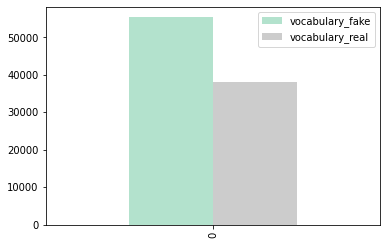

In [ ]:
fact_type_vocabulary_that_overlaps = {}
fact_type_vocabulary_that_overlaps['vocabulary_fake'] = len(vocabulary_fake)
fact_type_vocabulary_that_overlaps['vocabulary_real'] = len(vocabulary_real)

fact_type_vocabulary_that_overlaps_df = pd.DataFrame([fact_type_vocabulary_that_overlaps])
fact_type_vocabulary_that_overlaps_df.plot.bar(cmap = 'Pastel2')

Having specific vocabulary

In [ ]:
# select vocabulary common for both real and fake facts 
vocabulary_common = vocabulary_real.intersection(vocabulary_fake)

# as well as the specific vocabulary per each type of fact
vocabulary_real_specific = vocabulary_real - vocabulary_common
vocabulary_fake_specific = vocabulary_fake - vocabulary_common

vocabulary common size: 19961
vocabulary fake specific size: 35376
vocabulary real specific size: 18159


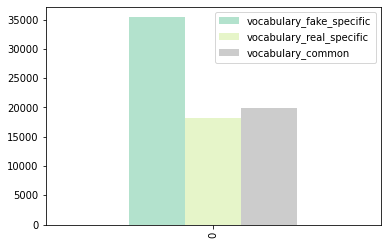

In [ ]:
fact_type_vocabulary_that_overlaps = {}
fact_type_vocabulary_that_overlaps['vocabulary_fake_specific'] = len(vocabulary_fake_specific)
fact_type_vocabulary_that_overlaps['vocabulary_real_specific'] = len(vocabulary_real_specific)
fact_type_vocabulary_that_overlaps['vocabulary_common'] = len(vocabulary_common)

print(f'vocabulary common size: {len(vocabulary_common)}')
print(f'vocabulary fake specific size: {len(vocabulary_fake_specific)}')
print(f'vocabulary real specific size: {len(vocabulary_real_specific)}')

fact_type_vocabulary_that_overlaps_df = pd.DataFrame([fact_type_vocabulary_that_overlaps])
fact_type_vocabulary_that_overlaps_df.plot.bar(cmap = 'Pastel2')



*   We see that fake news and real news use different vocabulary (that overlaps)
*   Fake news category has larger vocabulary than real news

We don't need to enrich the general vocabulary with additional fake news text data - fake_rest_df that we saved earlier. We can use CountVectorizer to mark if a specific word of a vocabulary is used in a document and then use Bernoully Naive Bayes Classifier model to distinguish between two categories of documents



In [ ]:
# We join sentences and then split text into word tokens
tokens = nltk.word_tokenize(' '.join(text_data))
vocabulary = set(tokens)

print(f'Size of full vocabulary: {len(vocabulary)}')

Size of full vocabulary: 73496


# **Text Data Cleaning**
Let's remove stop words

In [ ]:
# remove stop words
words_to_remove = set(stopwords.words('english'))
filtered_vocabulary = vocabulary - words_to_remove

print(f'Size of full filtered vocabulary: {len(filtered_vocabulary)}')

Size of full filtered vocabulary: 73345


In [ ]:
filtered_tokens = [t for t in tokens if t in filtered_vocabulary]

# Frequency distribution of tokens

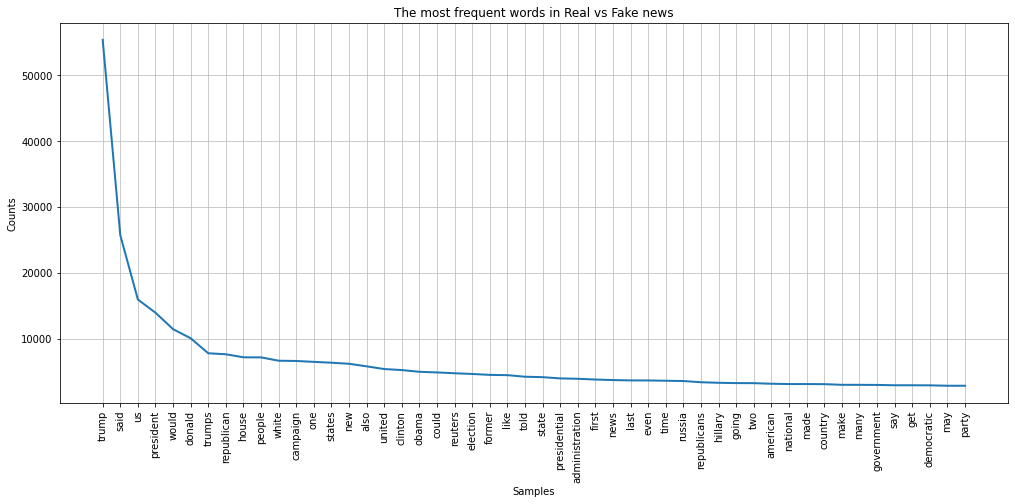

In [ ]:
freq_tokens = nltk.FreqDist(filtered_tokens)

plt.figure(figsize = (17, 7))
freq_tokens.plot(50, title = 'The most frequent words in Real vs Fake news')

Let's look at the most discussed terms in fake news

(-0.5, 1599.5, 799.5, -0.5)

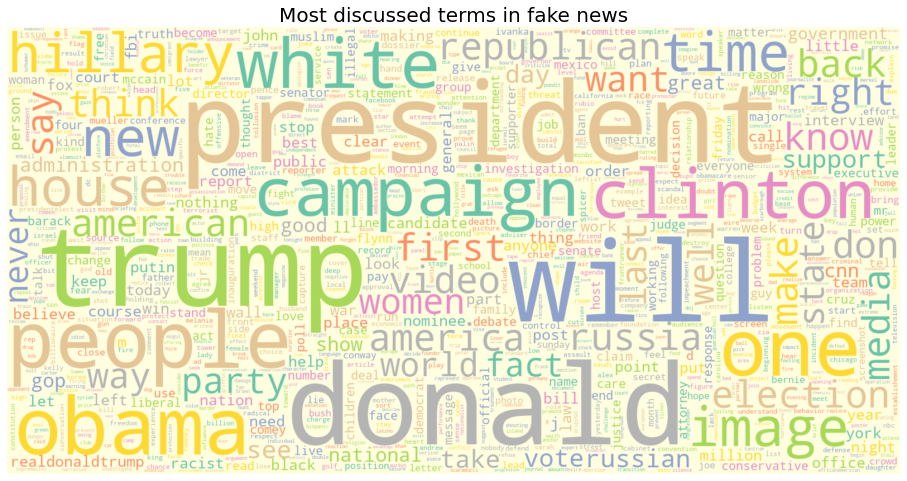

In [ ]:
freq_tokens_fake = nltk.FreqDist(tokens_fake_facts)
# The wordcloud 
plt.figure(figsize = (16, 13))
wc = WordCloud(background_color = 'lightyellow', colormap = 'Set2', max_words = 1000, max_font_size = 200,  width = 1600, height = 800)
wc.generate(" ".join(freq_tokens_fake))
plt.title('Most discussed terms in fake news', fontsize = 20)
plt.imshow(wc.recolor( colormap = 'Set2' , random_state = 17), alpha = 0.98, interpolation = "bilinear", )
plt.axis('off')

(-0.5, 1599.5, 799.5, -0.5)

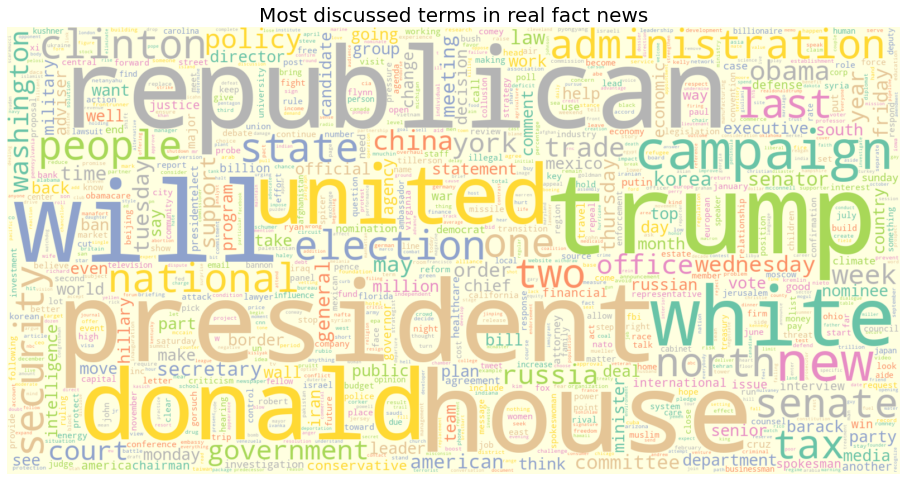

In [ ]:
freq_tokens_real = nltk.FreqDist(tokens_real_facts)

# The wordcloud 
plt.figure(figsize = (16, 13))
wc = WordCloud(background_color = 'lightyellow', colormap = 'Set2', max_words = 1000, max_font_size = 200,  width = 1600, height = 800)
wc.generate(" ".join(freq_tokens_real))
plt.title("Most discussed terms in real fact news", fontsize = 20)
plt.imshow(wc.recolor( colormap = 'Set2' , random_state = 17), alpha = 0.98, interpolation = "bilinear", )
plt.axis('off')

**Feature engineering**

In [ ]:
# get most frequent vocabulary tokens in amount of n
def get_vocabulary(tokens: list, n = 2000):

    vocabulary = tokens[: n] if len(tokens) >= n else tokens
    return vocabulary

**CountVectorizer** is a method to convert text to numerical data - a matrix of token counts.

In [ ]:
def preprocess_data(X_train, X_valid, X_test, vocabulary = None):

    # Use CountVectorizer to make the inputs to vectors
    if vocabulary is not None:
      count_vect = CountVectorizer(vocabulary = vocabulary, binary = True)
    else:
      count_vect = CountVectorizer(binary = True)

    X_train = count_vect.fit_transform(X_train)
    X_valid = count_vect.transform(X_valid)
    X_test = count_vect.transform(X_test)

    return X_train, X_valid, X_test

In [ ]:
ordered_tokens = list(freq_tokens)



**Bernoulli Naive Bayes Classifier**

Naive Bayes classifier designed for binary features of Bernoulli models

In [ ]:
classifier = BernoulliNB(alpha = 1, fit_prior = False)

training_accuracy = []
validation_accuracy = []

best_k = 0
best_valid_accuracy = 0

l = len(ordered_tokens)
k_range = list(range(500, 1700, 100)) + list(range(1700, l, 500))

for k in k_range:
  vocabulary = get_vocabulary(ordered_tokens, k)
  X_train_prep, X_valid_prep, X_test_prep = preprocess_data(X_train, X_valid, X_test, vocabulary)

  classifier.fit(X_train_prep, y_train)

  train_accuracy = classifier.score(X_train_prep, y_train)
  valid_accuracy = classifier.score(X_valid_prep, y_valid)

  if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    best_k = k

  training_accuracy.append(train_accuracy)
  validation_accuracy.append(valid_accuracy)

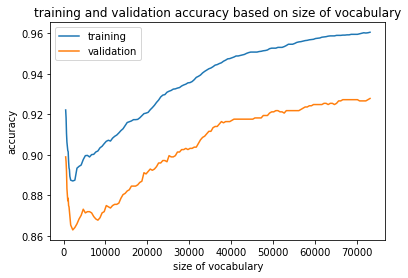

In [ ]:
size_of_vocabulary = k_range
plt.plot(
    size_of_vocabulary, 
    training_accuracy, 
    size_of_vocabulary, 
    validation_accuracy
)
plt.xlabel("size of vocabulary")
plt.legend(['training', 'validation'])
plt.ylabel('accuracy')
plt.title('training and validation accuracy based on size of vocabulary')
plt.show()

In [ ]:
vocabulary = get_vocabulary(ordered_tokens, best_k)
X_train_prep, X_valid_prep, X_test_prep = preprocess_data(X_train, X_valid, X_test, vocabulary)

In [ ]:
classifier = BernoulliNB(alpha = 1.0, fit_prior = False)
classifier.fit(X_train_prep, y_train)

print(best_k)


73200


# **Error analyses**
Confucion matrix for the training data

<Figure size 288x288 with 0 Axes>

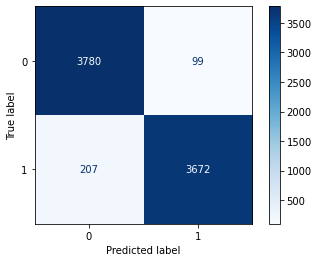

In [ ]:
plt.figure(figsize = (4, 4))
plot_confusion_matrix(classifier, X_train_prep, y_train, cmap = 'Blues')

Confucion matrix for the validation data

<Figure size 288x288 with 0 Axes>

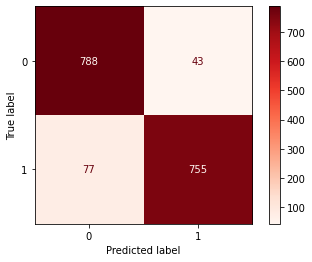

In [ ]:
plt.figure(figsize = (4, 4))
plot_confusion_matrix(classifier, X_valid_prep, y_valid, cmap = 'Reds')

Confucion matrix for the testing data

<Figure size 288x288 with 0 Axes>

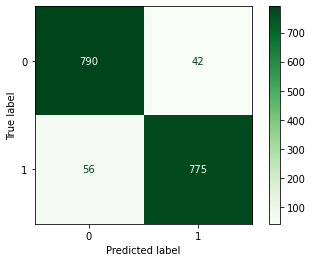

In [ ]:
plt.figure(figsize = (4, 4))
plot_confusion_matrix(classifier, X_test_prep, y_test, cmap = 'Greens')

In both cases, for training and validation data, the number of **false negative** errors is bigger than the number of **false positive** errors. So the model will classify real news as fake with higher probability than

Look at misclassified sample

In [ ]:
y_train_pred = classifier.predict(X_train_prep)

In [ ]:
X_train_df = pd.DataFrame(X_train)
X_train_df['y_train_pred'] = y_train_pred
X_train_df['y_train_true'] = y_train

In [ ]:
misclassified_train_df = X_train_df.query('y_train_pred != y_train_true')
misclassified_train_df.head()

,text_combined,y_train_pred,y_train_true
9255,trump should stop attacking minority groups se...,0,1
16254,terrific president trump takes on the united n...,1,0
3903,trump signs spending bill averting government ...,0,1
9233,trump disappointed by republican criticism of ...,0,1
19231,obamaappointed fed judge clears those in limbo...,1,0


In [ ]:
misclassified_train_df.shape

(306, 3)

For the training data we have 306 misclassified samples

# **Accuracy Scores**

In [ ]:
train_accuracy = classifier.score(X_train_prep, y_train)
valid_accuracy = classifier.score(X_valid_prep, y_valid)
test_accuracy = classifier.score(X_test_prep, y_test)

print(f'Accuracy of train data: {train_accuracy}')
print(f'Accuracy of validation data: {valid_accuracy}')
print(f'Accuracy of test data: {test_accuracy}')

Accuracy of train data: 0.9605568445475638
Accuracy of validation data: 0.9278412507516537
Accuracy of test data: 0.9410703547805171
